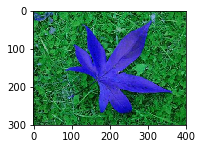

In [30]:
# -*- coding: utf-8 -*-

import numpy as np
from skimage import img_as_float
from skimage.color import rgb2lab
from skimage.segmentation import slic
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import cv2
# from google.colab.patches import cv2
from skimage.segmentation import mark_boundaries
import os
#-----------------------------------------------------------------------
uniq_sigma = uniqueness_sigma=0.25
dist_sigma = distribution_sigma=20.0
k=6.0
alpha=0.033
beta=0.033
nsegments=300
#-----------------------------custom functions--------------------------
def __gaussian_weight(array, sigma):
        weight = np.exp(-cdist(array, array) ** 2 / (2 * sigma ** 2))
        weight /= weight.sum(axis=1)[:, None]
        return weight

def __gaussian_weight2(array1, array2, alpha, beta):
        weight = np.exp(-0.5*(alpha*cdist(array1, array1)**2 +beta*cdist(array2,array2)**2))
        weight /= weight.sum(axis=1)[:, None]
        return weight
#-------------------------------input image----------------------------------------
"""input:- image in RGB uint8
output:- saliency map in uint8"""
cwd = os.getcwd()
imagepath=os.path.join(cwd,'leaf.jpg')
image=cv2.imread(imagepath)
plt.subplot(121),plt.imshow(image)
plt.show()
#-------------------------------abstraction--------------------------
nrgb = img_as_float(image)
lab = rgb2lab(nrgb)
nlab = (lab + np.array([0, 128, 128])) / np.array([100, 255, 255])
# generate superpixels
superpixels = slic(lab, nsegments,enforce_connectivity=True, compactness=30.0,convert2lab=False)
# --- Code fro plotting super pixels ---
#fig = plt.figure("Superpixels -- %d segments" % (nsegments))
#ax = fig.add_subplot(1, 1, 1)
#ax.imshow(mark_boundaries(image, superpixels))


n_segments = superpixels.max() + 1

# construct position matrix
max_y, max_x = np.array(superpixels.shape) - 1
x = np.linspace(0, max_x, image.shape[1]) / max_x
y = np.linspace(0, max_y, image.shape[0]) / max_y
position = np.dstack((np.meshgrid(x, y)))
# compute mean color and position
mean_lab = np.zeros((n_segments, 3))
mean_rgb = np.zeros((n_segments, 3))
mean_position = np.zeros((n_segments, 2))
for superpixel in np.unique(superpixels):
            mask = superpixels == superpixel
            mean_lab[superpixel, :] = nlab[mask, :].mean(axis=0)
            mean_rgb[superpixel, :] = nrgb[mask, :].mean(axis=0)
            mean_position[superpixel, :] = position[mask, :].mean(axis=0)


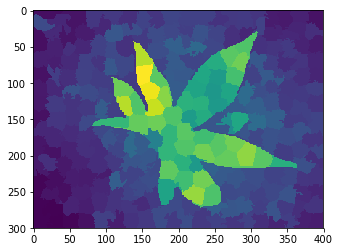

In [31]:
#------------------------------uniqueness-------------------------------
weight0= __gaussian_weight(mean_position,uniq_sigma)
uniqueness = (cdist(mean_lab,mean_lab) ** 2 * weight0).sum(axis=1)
#normalise
uniqueness=(uniqueness-uniqueness.min()) / (uniqueness.max() -uniqueness.min() + 1e-13)
result = np.zeros(image.shape[:2])
for superpixel in np.unique(superpixels):
            mask = superpixels == superpixel
            result[mask] =uniqueness[superpixel]
plt.imshow(result)
plt.show()

